<a href="https://colab.research.google.com/github/Feru34/Modelos_Toronbolo/blob/main/k_Nearest_Neighbor_and_Clustering_k_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementción k-Nearest Neighbor y Clustering k-Means AI Computer Society

Integrantes:
- Felipe Rueda
- Johan Suarez

Fuente de los datos: https://www.kaggle.com/code/samuelcortinhas/k-nearest-neighbours-knn-from-scratch/notebook

# k-Nearest Neighbor

El algoritmo **K-Nearest Neighbors (KNN)** es un método de aprendizaje supervisado utilizado tanto para clasificación como para regresión. Es un algoritmo basado en instancias, lo que significa que no tiene una etapa de entrenamiento como otros algoritmos, sino que toma decisiones basadas en los datos directamente.

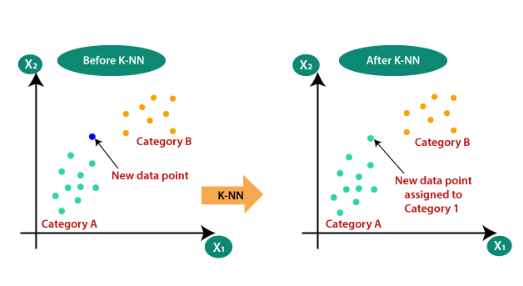


En este cuaderno, motivaremos e implementaremos el algoritmo de k-Vecinos Más Cercanos (kNN) desde cero.

Este código configura el entorno para análisis de datos y visualización:

1. **NumPy (`np`)**: Para cálculos numéricos eficientes.
2. **Pandas (`pd`)**: Para manipulación de datos tabulares.
3. **Seaborn (`sns`)**: Para visualizaciones estadísticas con estilo personalizado.
4. **Matplotlib (`plt`)**: Para crear gráficos; `%matplotlib inline` muestra gráficos en el notebook.
5. **`train_test_split`**: Divide los datos en conjuntos de entrenamiento y prueba (de scikit-learn).
6. **Scipy.stats**: Proporciona herramientas estadísticas avanzadas.

Todo esto es esencial para análisis, modelado y visualización de datos.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from scipy import stats
import time

Aplicaremos el algoritmo kNN en el famoso conjunto de datos de cáncer de mama de UCI. Este es un problema de clasificación binaria cuyo objetivo es predecir si un paciente tiene cáncer de mama o no, utilizando varias características extraídas de imágenes.

In [ ]:
# Load data
data = pd.read_csv('data.csv', index_col='id').reset_index(drop=True)
data.drop('Unnamed: 32', axis=1, inplace=True)

# Preview data
print('Dataframe shape:', data.shape)
data.head(3)

Dataframe shape: (569, 31)


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


Acontinuación vamos a :
1. **Separar datos:**
   - `X`: Contiene las características (todas las columnas excepto `diagnosis`).
   - `y`: Contiene las etiquetas (`diagnosis`).

2. **Codificar etiquetas:**
   - Convierte `y` en valores binarios: `1` si es maligno (`M`), `0` si es benigno.

In [ ]:
# Features and labels
X = data.drop('diagnosis', axis=1)
y = data['diagnosis']

# Encode target to binary
y = (y=='M').astype('int')

In [ ]:
# Split dataset into training and testing data (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

### Conceptos Clave de KNN:
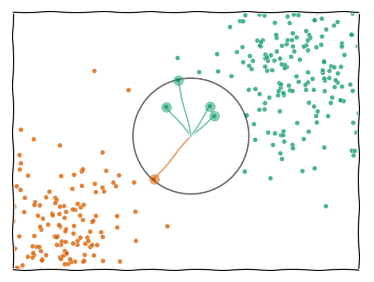
1. **Funcionamiento Básico:**
   - Cuando se recibe un dato nuevo para clasificar o predecir, el algoritmo:
     1. Calcula la distancia entre el nuevo dato y todos los datos existentes en el conjunto de entrenamiento. Las distancias más comunes son:
        - **Euclidiana** (la más usada)
        - Manhattan
        - Coseno

        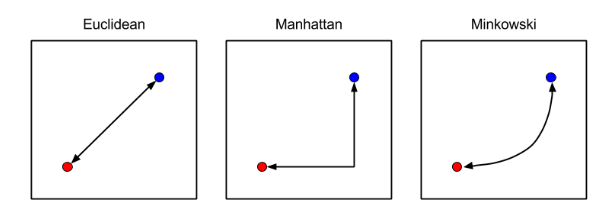
     2. Identifica los **K vecinos más cercanos** según estas distancias.
     3. Realiza una decisión basada en los datos vecinos:
        - **Clasificación:** Se asigna la clase más frecuente entre los vecinos (votación por mayoría).
        - **Regresión:** Se calcula el promedio de los valores objetivo de los vecinos.

2. **Parámetro K:**
   - Es el número de vecinos que el algoritmo considera.
   - Si \(K\) es pequeño, el modelo puede ser sensible al ruido (sobreajuste).
   - Si \(K\) es grande, el modelo puede suavizar demasiado y perder precisión (subajuste).




A continuación, se implementa una clase personalizada `kNN` para el algoritmo de k-Vecinos Más Cercanos:

1. **Inicialización:** Configura el número de vecinos `k`, la métrica de distancia (euclidiana, Manhattan o Minkowski) y parámetros opcionales.
2. **Funciones de distancia:** Calcula distancias entre puntos según la métrica elegida.
3. **`fit`:** Almacena los datos de entrenamiento y etiquetas.
4. **`predict`:** Predice clases para puntos de prueba buscando los `k` vecinos más cercanos y seleccionando la clase mayoritaria.
5. **`get_neighbours`:** Calcula distancias, ordena y selecciona los `k` vecinos más cercanos.

**Propósito:** Implementar kNN desde cero con soporte para múltiples métricas de distancia.

In [ ]:
class kNN():
    '''k-Nearest Neighbours'''
    # Initialise
    def __init__(self, k=3, metric='euclidean', p=None):
        self.k = k
        self.metric = metric
        self.p = p

    # Euclidean distance (l2 norm)
    def euclidean(self, v1, v2):
        return np.sqrt(np.sum((v1-v2)**2))

    # Manhattan distance (l1 norm)
    def manhattan(self, v1, v2):
        return np.sum(np.abs(v1-v2))

    # Minkowski distance (lp norm)
    def minkowski(self, v1, v2, p=2):
        return np.sum(np.abs(v1-v2)**p)**(1/p)

    # Store train set
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    # Make predictions
    def predict(self, X_test):
        preds = []
        # Loop over rows in test set
        for test_row in X_test:
            nearest_neighbours = self.get_neighbours(test_row)
            majority = stats.mode(nearest_neighbours, keepdims=True).mode[0]

            preds.append(majority)
        return np.array(preds)

    # Get nearest neighbours
    def get_neighbours(self, test_row):
        distances = list()

        # Calculate distance to all points in X_train
        for (train_row, train_class) in zip(self.X_train, self.y_train):
            if self.metric=='euclidean':
                dist = self.euclidean(train_row, test_row)
            elif self.metric=='manhattan':
                dist = self.manhattan(train_row, test_row)
            elif self.metric=='minkowski':
                dist = self.minkowski(train_row, test_row, self.p)
            else:
                raise NameError('Supported metrics are euclidean, manhattan and minkowski')
            distances.append((dist, train_class))

        # Sort distances
        distances.sort(key=lambda x: x[0])

        # Identify k nearest neighbours
        neighbours = list()
        for i in range(self.k):
            neighbours.append(distances[i][1])

        return neighbours

1. **Calcular precisión:**  
   La función `accuracy` mide el porcentaje de predicciones correctas comparando `preds` con `y_test`.

2. **Probar kNN con diferentes métricas:**  
   - Para cada métrica (`euclidean` y `manhattan`):
     - Se inicializa un modelo `kNN` con `k=5` y la métrica correspondiente.
     - El modelo se entrena con los datos de entrenamiento (`fit`).
     - Se realizan predicciones sobre los datos de prueba (`predict`).
     - Se imprime la precisión calculada para cada métrica.

**Propósito:** Comparar el rendimiento del algoritmo kNN usando distintas métricas de distancia.

In [ ]:
#  Function to calculate accuracy
def accuracy(preds, y_test):
    return 100 * (preds == y_test).mean()

# Apply our kNN algorithm
for metric in ['euclidean', 'manhattan']:
    clf = kNN(k=5, metric=metric)
    clf.fit(X_train.values, y_train.values)
    preds = clf.predict(X_test.values)
    print(f'Metric: {metric}, accuracy: {accuracy(preds, y_test):.3f} %')

Metric: euclidean, accuracy: 87.719 %
Metric: manhattan, accuracy: 91.228 %


## Resultados

Haremos una matriz de confusión en los siguientes pasos:
1. **Importar herramientas:**  
   - `confusion_matrix`: Genera la matriz de confusión, que muestra el rendimiento del modelo al clasificar las etiquetas.

2. **Aplicar kNN con distintas métricas:**  
   - Para cada métrica (`euclidean` y `manhattan`), se entrena el modelo `kNN` y se obtienen las predicciones.

3. **Generar matriz de confusión:**  
   - Compara las etiquetas reales (`y_test`) con las predicciones (`preds`).
   - Imprime la matriz de confusión, que indica:
     - Verdaderos positivos (TP)
     - Verdaderos negativos (TN)
     - Falsos positivos (FP)
     - Falsos negativos (FN)

**Propósito:** Evaluar cómo se distribuyen los aciertos y errores de clasificación para cada métrica de distancia.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Obtener matriz de confusión
for metric in ['euclidean', 'manhattan']:
    clf = kNN(k=5, metric=metric)
    clf.fit(X_train.values, y_train.values)
    preds = clf.predict(X_test.values)

    # Matriz de confusión
    cm = confusion_matrix(y_test, preds)
    print(f"Metric: {metric}")
    print("Confusion Matrix:")
    print(cm)


Metric: euclidean
Confusion Matrix:
[[71  9]
 [ 5 29]]
Metric: manhattan
Confusion Matrix:
[[75  5]
 [ 5 29]]


El **Classification Report** ofrece un resumen detallado del rendimiento de un modelo de clasificación utilizando las siguientes métricas clave:
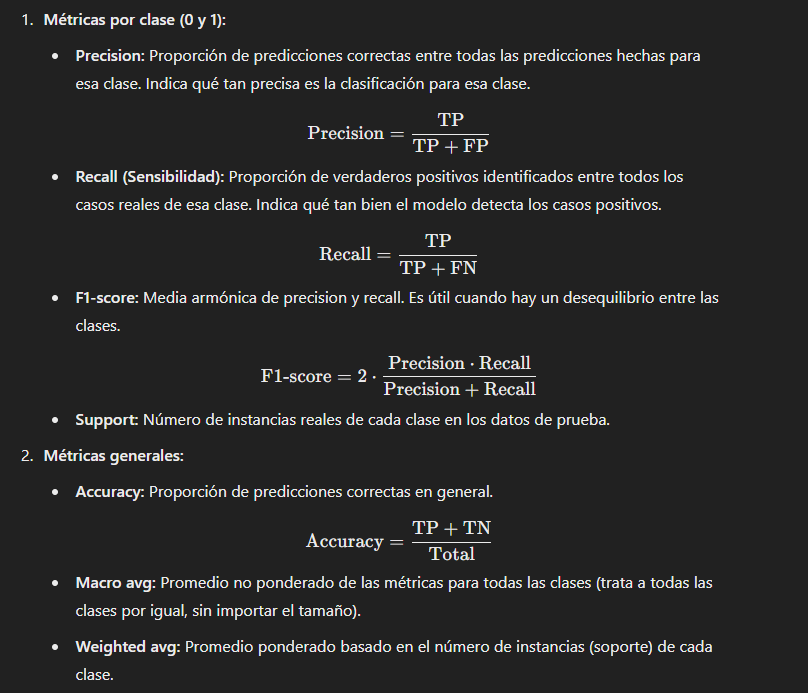

**Uso:**  
Estas métricas ayudan a comprender el rendimiento del modelo en términos de precisión, sensibilidad y balance entre las clases, especialmente útil en casos con datos desbalanceados.

In [ ]:
    # Reporte de clasificación
    print("Classification Report:")
    print(classification_report(y_test, preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        80
           1       0.85      0.85      0.85        34

    accuracy                           0.91       114
   macro avg       0.90      0.90      0.90       114
weighted avg       0.91      0.91      0.91       114



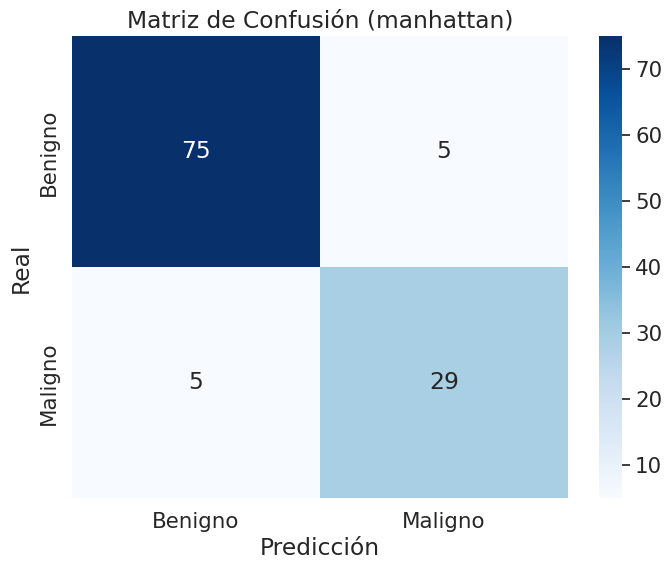

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
plt.title(f"Matriz de Confusión ({metric})")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


## Conclusiones:

1. **Rendimiento general:** El modelo tiene un **91% de precisión global**, con un buen equilibrio entre precisión y sensibilidad.

2. **Clase 0 (negativos):** Excelente rendimiento (F1-score: 94%), detecta y clasifica correctamente la mayoría de los casos negativos.

3. **Clase 1 (positivos):** Buen desempeño (F1-score: 85%), pero podría mejorarse para reducir falsos negativos si son críticos.

4. **Recomendación:** Ajustar el modelo (umbral o balance de clases) si la prioridad es maximizar la detección de positivos.

 **Ventajas de KNN:**
   - Simplicidad: Fácil de entender e implementar.
   - No necesita entrenamiento explícito: Al ser un algoritmo basado en instancias, utiliza directamente los datos.

 **Desventajas de KNN:**
   - Computacionalmente intensivo: A medida que aumenta el tamaño del conjunto de datos, el cálculo de distancias puede ser costoso.
   - Dependencia de la escala: Los resultados pueden variar según la escala de las variables; por ello, es importante normalizar o estandarizar los datos.
   - Sensible a la elección de \(K\) y a los datos desbalanceados (por ejemplo, si una clase domina).

# Clustering k-Means
fuente de datos: https://www.kaggle.com/code/prashant111/k-means-clustering-with-python

Aquí tienes una introducción en español explicando el algoritmo K-Means, que puedes incluir en tu Jupyter Notebook antes de documentar el código:

---

## Introducción al Algoritmo K-Means

K-Means es un algoritmo de aprendizaje no supervisado utilizado para la agrupación de datos en subconjuntos llamados **clusters**. Su objetivo principal es encontrar grupos intrínsecos dentro de un conjunto de datos no etiquetado, permitiendo inferir estructuras subyacentes en los datos.

### Conceptos Claves

- **Centroides:** Son puntos que representan el centro de cada clúster. En cada iteración, los centroides se ajustan para minimizar la distancia entre los puntos de datos y sus respectivos centroides.
- **Distancia Euclidiana:** Es la métrica más comúnmente utilizada para asignar cada punto de datos al clúster más cercano.
- **Iteración:** El algoritmo K-Means se ejecuta de forma iterativa hasta cumplir con un criterio de parada.

### Funcionamiento del Algoritmo

1. Se elige un número de clusters \( K \) y se inicializan \( K \) centroides de manera aleatoria.
2. **Paso de asignación:** Cada punto de datos se asigna al clúster cuyo centroide esté más cercano (medido con distancia Euclidiana).
3. **Paso de actualización:** Se recalculan los centroides tomando el promedio de los puntos de datos asignados a cada clúster.
4. Se repiten los pasos 2 y 3 hasta cumplir con un criterio de parada, como:
   - No hay cambios en la asignación de los puntos.
   - La variación en la posición de los centroides es mínima.
   - Se alcanza un número máximo de iteraciones.

### Convergencia y Óptimos Locales

El algoritmo está garantizado a converger, aunque el resultado puede depender de la inicialización de los centroides. Para mejorar la estabilidad, se recomienda ejecutar K-Means varias veces con diferentes centroides iniciales y seleccionar la mejor solución basada en métricas como la **inercia** (suma de distancias al centroide dentro de cada clúster).

A continuación, se procederá a documentar el código que implementa el algoritmo K-Means.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for statistical data visualization
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

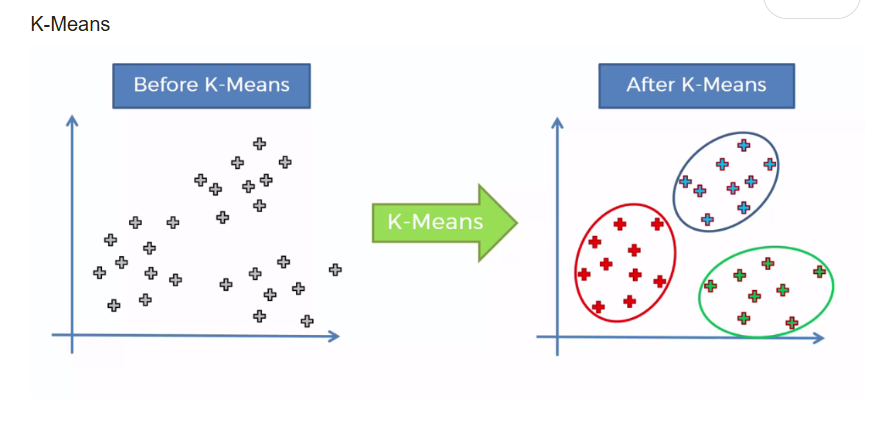
  
)

Este fragmento de código carga un conjunto de datos desde un archivo CSV llamado **"Live_20210128.csv"** utilizando la función `pd.read_csv()` de **Pandas**. Luego, `df.head()` muestra las primeras cinco filas del DataFrame resultante. Esto permite una inspección rápida de la estructura del conjunto de datos, incluyendo nombres de columnas y los primeros valores, facilitando la comprensión inicial antes de realizar análisis más profundos.

In [5]:
df = pd.read_csv("Live_20210128.csv")
df.head()

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
0,1,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,NaN,NaN,NaN,NaN
1,2,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,NaN,NaN,NaN,NaN
2,3,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,NaN,NaN,NaN,NaN
3,4,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,NaN,NaN,NaN,NaN
4,5,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,NaN,NaN,NaN,NaN


In [6]:
df.shape

(7050, 16)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   status_id         7050 non-null   int64  
 1   status_type       7050 non-null   object 
 2   status_published  7050 non-null   object 
 3   num_reactions     7050 non-null   int64  
 4   num_comments      7050 non-null   int64  
 5   num_shares        7050 non-null   int64  
 6   num_likes         7050 non-null   int64  
 7   num_loves         7050 non-null   int64  
 8   num_wows          7050 non-null   int64  
 9   num_hahas         7050 non-null   int64  
 10  num_sads          7050 non-null   int64  
 11  num_angrys        7050 non-null   int64  
 12  Column1           0 non-null      float64
 13  Column2           0 non-null      float64
 14  Column3           0 non-null      float64
 15  Column4           0 non-null      float64
dtypes: float64(4), int64(10), object(2)
memory

In [8]:
df.isnull().sum()

,0
status_id,0
status_type,0
status_published,0
num_reactions,0
num_comments,0
num_shares,0
num_likes,0
num_loves,0
num_wows,0
num_hahas,0


A partir de la vista previa del dataset, se pueden hacer las siguientes observaciones:

1. **Estructura de Datos:** El dataset contiene múltiples columnas con información sobre publicaciones en redes sociales, incluyendo métricas de interacción como reacciones, comentarios y compartidos.

2. **Tipos de Publicaciones:** La columna `status_type` indica diferentes tipos de contenido, como **video** y **photo**, lo que sugiere que se pueden analizar diferencias en el engagement según el formato.

3. **Fecha y Hora de Publicación:** La columna `status_published` almacena la fecha y hora en que se publicó cada contenido, lo que permite analizar tendencias temporales en la interacción de los usuarios.

4. **Métricas de Interacción:** Existen columnas que miden el número total de **reacciones**, **comentarios** y **compartidos**, así como reacciones específicas (`num_likes`, `num_loves`, `num_wows`, `num_hahas`, `num_sads`, `num_angrys`). Esto permite segmentar el engagement por tipo de reacción.

5. **Valores Nulos:** Se observan varias columnas (`Column1`, `Column2`, `Column3`, `Column4`) que contienen valores **NaN** en todas las filas visibles. Esto sugiere que podrían ser columnas irrelevantes o vacías, que deberían ser inspeccionadas antes del análisis.

6. **Posibles Análisis:** Se pueden realizar análisis como:
   - Comparación del engagement entre **videos** y **fotos**.
   - Evaluación de la distribución de interacciones en distintos tipos de publicaciones.
   - Análisis temporal de reacciones para identificar patrones de comportamiento de los usuarios.

Para un análisis más detallado, se recomienda explorar estadísticas descriptivas (`df.describe()`), verificar valores nulos (`df.isnull().sum()`) y revisar la estructura general del dataset (`df.info()`).

In [9]:
df.drop(['Column1', 'Column2', 'Column3', 'Column4'], axis=1, inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   status_id         7050 non-null   int64 
 1   status_type       7050 non-null   object
 2   status_published  7050 non-null   object
 3   num_reactions     7050 non-null   int64 
 4   num_comments      7050 non-null   int64 
 5   num_shares        7050 non-null   int64 
 6   num_likes         7050 non-null   int64 
 7   num_loves         7050 non-null   int64 
 8   num_wows          7050 non-null   int64 
 9   num_hahas         7050 non-null   int64 
 10  num_sads          7050 non-null   int64 
 11  num_angrys        7050 non-null   int64 
dtypes: int64(10), object(2)
memory usage: 661.1+ KB


In [11]:
df.describe()

,status_id,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
count,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000
mean,3525.500000,230.117163,224.356028,40.022553,215.043121,12.728652,1.289362,0.696454,0.243688,0.113191
std,2035.304031,462.625309,889.636820,131.599965,449.472357,39.972930,8.719650,3.957183,1.597156,0.726812
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1763.250000,17.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3525.500000,59.500000,4.000000,0.000000,58.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5287.750000,219.000000,23.000000,4.000000,184.750000,3.000000,0.000000,0.000000,0.000000,0.000000
max,7050.000000,4710.000000,20990.000000,3424.000000,4710.000000,657.000000,278.000000,157.000000,51.000000,31.000000


In [12]:
df['status_id'].unique()

array([   1,    2,    3, ..., 7048, 7049, 7050])

In [13]:
len(df['status_id'].unique())

7050

In [14]:
df['status_published'].unique()

array(['4/22/2018 6:00', '4/21/2018 22:45', '4/21/2018 6:17', ...,
       '9/21/2016 23:03', '9/20/2016 0:43', '9/10/2016 10:30'],
      dtype=object)

In [15]:
len(df['status_published'].unique())

6913

In [16]:
df['status_type'].unique()

array(['video', 'photo', 'link', 'status'], dtype=object)

In [17]:
len(df['status_type'].unique())

4

A partir de la exploración realizada en el dataset, se pueden extraer las siguientes conclusiones:

1. **Cantidad de Publicaciones:** Se identifican **7,050 publicaciones únicas** (`status_id`), lo que indica que el dataset cubre una amplia cantidad de contenido publicado.

2. **Diversidad Temporal:** Hay **6,913 fechas únicas** en la columna `status_published`, lo que sugiere que hay publicaciones en momentos distintos, aunque algunos podrían estar duplicados o repetidos.

3. **Tipos de Publicaciones:** Se identifican **cuatro tipos de publicaciones** en `status_type`: **video, photo, link y status**. Esto permite realizar un análisis comparativo del impacto de cada tipo de contenido en la interacción de los usuarios.

4. **Limpieza de Datos:** Se han eliminado las columnas `status_id` y `status_published` (`df.drop()`), lo que indica que no serán necesarias para el análisis de clustering, probablemente porque no aportan información relevante para la segmentación.

5. **Integridad de Datos:** Según `df.info()`, todas las columnas relevantes después de la limpieza contienen **7,050 valores no nulos**, lo que indica que no hay valores faltantes en las métricas de interacción (`num_reactions`, `num_comments`, `num_shares`, etc.), facilitando el análisis sin necesidad de imputación de datos.


In [18]:
df.drop(['status_id', 'status_published'], axis=1, inplace=True)

La eliminación de las columnas **`status_id`** y **`status_published`** indica que estas variables no serán consideradas en el análisis.

### **Razones para eliminar estas columnas:**
1. **`status_id`** es simplemente un identificador único de cada publicación y no aporta información relevante para el clustering, ya que no influye en las métricas de interacción.
2. **`status_published`** representa la fecha y hora de publicación, lo que podría ser útil para análisis temporales, pero no es una variable numérica directamente utilizable en el algoritmo **K-Means** sin una transformación adecuada.

### **Implicaciones:**
- Con esta eliminación, el dataset queda reducido a las variables más relevantes para el análisis de clustering, principalmente las métricas de interacción (`num_reactions`, `num_comments`, `num_shares`, etc.).
- Si en un futuro se requiere realizar análisis de tendencias temporales, habría que reconsiderar la eliminación de `status_published` o transformarla en variables útiles como el **día de la semana**, **hora del día** o **mes de publicación**.


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   status_type    7050 non-null   object
 1   num_reactions  7050 non-null   int64 
 2   num_comments   7050 non-null   int64 
 3   num_shares     7050 non-null   int64 
 4   num_likes      7050 non-null   int64 
 5   num_loves      7050 non-null   int64 
 6   num_wows       7050 non-null   int64 
 7   num_hahas      7050 non-null   int64 
 8   num_sads       7050 non-null   int64 
 9   num_angrys     7050 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 550.9+ KB


A partir de la exploración del dataset, se pueden extraer las siguientes conclusiones:

1. **Datos Limpiados y Completo:** El dataset tiene **7,050 registros** y no presenta valores nulos en ninguna de sus columnas, lo que facilita el análisis sin necesidad de imputación.

2. **Características del Dataset:** Contiene **10 columnas**, con métricas de interacción (número de reacciones, comentarios, compartidos, etc.) y una variable categórica **`status_type`** que define el tipo de publicación.

3. **Tipos de Datos:** Todas las columnas, excepto `status_type` (tipo de publicación), son **variables numéricas (`int64`)**, lo que es ideal para aplicar **K-Means** después de codificar la variable categórica.

4. **Relevancia para Clustering:** La presencia de múltiples métricas de interacción sugiere que se pueden identificar grupos de publicaciones con patrones de engagement similares.


In [20]:
df.head()

,status_type,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,video,529,512,262,432,92,3,1,1,0
1,photo,150,0,0,150,0,0,0,0,0
2,video,227,236,57,204,21,1,1,0,0
3,photo,111,0,0,111,0,0,0,0,0
4,photo,213,0,0,204,9,0,0,0,0


# Creación del modelo


In [21]:
X = df

y = df['status_type']

In [22]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

X['status_type'] = le.fit_transform(X['status_type'])

y = le.transform(y)

El código realiza la **codificación de variables categóricas**, convirtiendo la columna `status_type` en valores numéricos utilizando `LabelEncoder` de **Scikit-learn**.

### **Explicación del proceso:**
1. **Definición de `X` y `y`:**  
   - `X = df` almacena el dataset completo.
   - `y = df['status_type']` extrae la columna de tipo de publicación.

2. **Codificación con `LabelEncoder`:**  
   - Se crea un objeto `LabelEncoder()`, que asigna un número único a cada categoría en `status_type`.
   - `le.fit_transform(X['status_type'])` convierte los valores de texto (`video`, `photo`, `link`, `status`) en valores enteros.
   - `y = le.transform(y)` asegura que `y` refleje la misma transformación.

### **Impacto en el dataset:**
- `status_type` deja de ser un **tipo de dato categórico** y se convierte en una variable **numérica**, facilitando su uso en **K-Means**, que solo trabaja con datos numéricos.
- Las publicaciones ahora están representadas por números, por ejemplo:
  - `video → 3`
  - `photo → 2`
  - `link → 1`
  - `status → 0`

In [23]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   status_type    7050 non-null   int64
 1   num_reactions  7050 non-null   int64
 2   num_comments   7050 non-null   int64
 3   num_shares     7050 non-null   int64
 4   num_likes      7050 non-null   int64
 5   num_loves      7050 non-null   int64
 6   num_wows       7050 non-null   int64
 7   num_hahas      7050 non-null   int64
 8   num_sads       7050 non-null   int64
 9   num_angrys     7050 non-null   int64
dtypes: int64(10)
memory usage: 550.9 KB


In [24]:
X.head()

,status_type,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,3,529,512,262,432,92,3,1,1,0
1,1,150,0,0,150,0,0,0,0,0
2,3,227,236,57,204,21,1,1,0,0
3,1,111,0,0,111,0,0,0,0,0
4,1,213,0,0,204,9,0,0,0,0


In [25]:
cols = X.columns

In [26]:
from sklearn.preprocessing import MinMaxScaler

ms = MinMaxScaler()

X = ms.fit_transform(X)

In [27]:
X = pd.DataFrame(X, columns=[cols])

El código realiza la **normalización de datos** utilizando `MinMaxScaler` de **Scikit-learn**, lo que es crucial antes de aplicar **K-Means** para evitar sesgos debido a diferencias de escala entre variables.

### **Explicación del proceso:**
1. **Obtener las columnas del DataFrame:**  
   `cols = X.columns` guarda los nombres de las columnas originales.

2. **Aplicar Min-Max Scaling:**  
   - `MinMaxScaler()` transforma los valores de cada columna en un rango de **0 a 1**.
   - `ms.fit_transform(X)` ajusta el escalador a los datos y transforma todas las variables.

3. **Convertir de nuevo en DataFrame:**  
   - `pd.DataFrame(X, columns=[cols])` devuelve el dataset a su formato original con los nombres de columna restaurados.

### **Impacto en el dataset:**
- **K-Means es sensible a la escala**, por lo que este paso es esencial para que ninguna variable con valores más grandes (como `num_reactions`) domine la segmentación.
- La transformación permite que todas las métricas de interacción tengan el mismo peso en la agrupación.


In [28]:
X.head()

,status_type,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,1.000000,0.112314,0.024393,0.076519,0.091720,0.140030,0.010791,0.006369,0.019608,0.0
1,0.333333,0.031847,0.000000,0.000000,0.031847,0.000000,0.000000,0.000000,0.000000,0.0
2,1.000000,0.048195,0.011243,0.016647,0.043312,0.031963,0.003597,0.006369,0.000000,0.0
3,0.333333,0.023567,0.000000,0.000000,0.023567,0.000000,0.000000,0.000000,0.000000,0.0
4,0.333333,0.045223,0.000000,0.000000,0.043312,0.013699,0.000000,0.000000,0.000000,0.0


# Entrenar al modelo con dos clusters

In [29]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0)

kmeans.fit(X)

KMeans(n_clusters=2, random_state=0)

In [30]:
kmeans.cluster_centers_

array([[9.54921576e-01, 6.46330441e-02, 2.67028654e-02, 2.93171709e-02,
        5.71231462e-02, 4.71007076e-02, 8.18581889e-03, 9.65207685e-03,
        8.04219428e-03, 7.19501847e-03],
       [3.28506857e-01, 3.90710874e-02, 7.54854864e-04, 7.53667113e-04,
        3.85438884e-02, 2.17448568e-03, 2.43721364e-03, 1.20039760e-03,
        2.75348016e-03, 1.45313276e-03]])

In [31]:
kmeans.inertia_

237.7572640441955

El código aplica el algoritmo **K-Means** con **2 clústeres** al conjunto de datos normalizado y extrae información relevante sobre los resultados del modelo.

### **Explicación del proceso:**
1. **Inicialización de K-Means:**
   - `KMeans(n_clusters=2, random_state=0)`: Se define el modelo con **2 clústeres**, lo que significa que el algoritmo agrupará las publicaciones en dos categorías según sus métricas de interacción.
   - `random_state=0`: Asegura que los resultados sean reproducibles (al ejecutar el mismo código varias veces, se obtendrán los mismos resultados).

2. **Entrenamiento del modelo:**
   - `kmeans.fit(X)`: Aplica K-Means a los datos normalizados, asignando cada publicación a un clúster.

3. **Centro de los clústeres (`cluster_centers_`):**
   - Se obtienen las coordenadas de los **centroides**, que representan el punto medio de cada clúster en el espacio de características.
   - Cada número en la matriz representa la media de los valores normalizados para cada variable dentro del clúster.

4. **Inercia (`inertia_`):**
   - La inercia mide la **suma de las distancias cuadradas** de cada punto a su clúster más cercano.
   - Un valor de **237.76** indica qué tan bien ajustado está el modelo: valores más bajos sugieren una mejor agrupación.


# Ver resultados

In [32]:
labels = kmeans.labels_

# check how many of the samples were correctly labeled
correct_labels = sum(y == labels)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))

Result: 4288 out of 7050 samples were correctly labeled.


In [33]:
print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

Accuracy score: 0.61


### **Análisis del Modelo de Clustering K-Means**

#### **1. Evaluación del Desempeño del Modelo**
- Se comparan las etiquetas asignadas por K-Means (`labels`) con las etiquetas reales (`y`).
- **4288 de 7050 muestras fueron correctamente etiquetadas**, lo que representa una **precisión del 61%** (`Accuracy score: 0.61`).
- **Interpretación:** K-Means no es un algoritmo supervisado, por lo que no busca replicar etiquetas reales. Sin embargo, un 61% de coincidencia sugiere que los grupos formados tienen cierta alineación con los tipos de publicación (`status_type`).



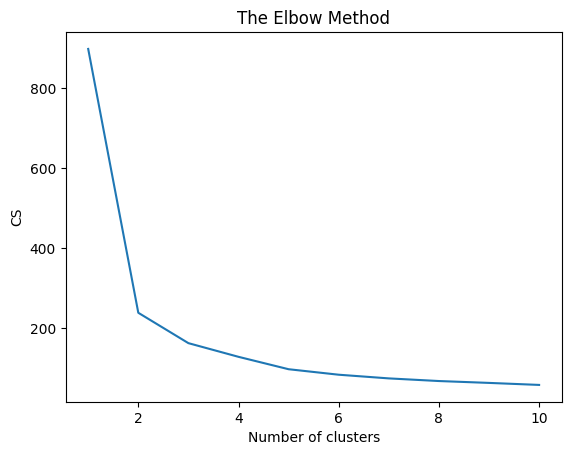

In [34]:
from sklearn.cluster import KMeans
cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

#### **2. Método del Codo para Selección de K**
- Se genera una gráfica del **método del codo** para determinar el número óptimo de clústeres (`K`).
- Se prueba K-Means con **valores de K entre 1 y 10**, registrando la **inercia** (distancia acumulada de los puntos a sus centroides).
- La gráfica muestra una disminución rápida de la inercia al aumentar K, pero con un punto de inflexión alrededor de **K=3 o K=4**.
- **Conclusión:** El número óptimo de clústeres podría ser **3 o 4**, ya que después de ese punto la reducción en la inercia es mínima.

In [35]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2,random_state=0)

kmeans.fit(X)

labels = kmeans.labels_

# check how many of the samples were correctly labeled

correct_labels = sum(y == labels)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))

print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

Result: 4288 out of 7050 samples were correctly labeled.
Accuracy score: 0.61


# K-Means model with 3 clusters

In [36]:
kmeans = KMeans(n_clusters=3, random_state=0)

kmeans.fit(X)

# check how many of the samples were correctly labeled
labels = kmeans.labels_

correct_labels = sum(y == labels)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

Result: 4066 out of 7050 samples were correctly labeled.
Accuracy score: 0.58


# K-Means model with 4 clusters

In [37]:
kmeans = KMeans(n_clusters=4, random_state=0)

kmeans.fit(X)

# check how many of the samples were correctly labeled
labels = kmeans.labels_

correct_labels = sum(y == labels)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

Result: 4112 out of 7050 samples were correctly labeled.
Accuracy score: 0.58


### **Conclusiones sobre el Desempeño de K-Means con Diferentes Valores de K**

1. **Comparación de Accuracy Score:**
   - **K=2:** **61%** de precisión (4288/7050 correctamente etiquetados).
   - **K=3:** **58%** de precisión (4066/7050 correctamente etiquetados).
   - **K=4:** **58%** de precisión (4112/7050 correctamente etiquetados).

2. **Razón de la disminución en precisión con más clústeres:**
   - **No es un error**, sino un comportamiento esperable en K-Means.  
   - La métrica de **accuracy** no es la mejor forma de evaluar K-Means, ya que es un algoritmo **no supervisado**, es decir, no trata de replicar etiquetas preexistentes (`status_type`).
   - A medida que **K aumenta**, K-Means genera más clústeres y distribuye las muestras en grupos más pequeños. Sin embargo, la correspondencia con las etiquetas originales se reduce, lo que impacta en la precisión medida de forma supervisada.
   - **K-Means no está diseñado para clasificar datos en etiquetas predefinidas**, sino para encontrar estructuras inherentes en los datos, por lo que una menor precisión no implica necesariamente un peor desempeño del modelo.

3. **Cómo determinar el mejor número de clústeres:**
   - **Accuracy no es la métrica correcta para medir K-Means.**  
   - Se recomienda usar métricas adecuadas para clustering, como:
     - **Método del codo (Elbow Method)** → Evalúa la inercia y el punto de inflexión para determinar el número óptimo de K.
     - **Índice de Silhouette** → Mide la separación y cohesión entre clústeres, ayudando a determinar si los grupos están bien formados.

### **Conclusión Final**
- **El accuracy menor con K=3 o K=4 no es un error, sino una consecuencia natural del método K-Means.**
- Para evaluar correctamente el modelo, se deben usar métricas de clustering como **Silhouette Score** y **Elbow Method**, en lugar de comparar con etiquetas preexistentes.
- Se recomienda analizar los clústeres visualmente y calcular métricas de cohesión para validar la calidad del agrupamiento.